In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandomApply, RandomHorizontalFlip, RandomRotation
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define the neural network
class HandSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HandSignClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
# Set hyperparameters
batch_size = 48
learning_rate = 0.001
num_epochs = 10

In [5]:
# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomApply([RandomRotation(30)]),
    RandomApply([RandomHorizontalFlip()]),
    transforms.ToTensor(),
])

In [6]:
# Load dataset and split into training, validation, and testing sets
full_dataset = datasets.ImageFolder(root='../pre-images', transform=transform)

# Define the sizes for training, validation, and testing sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Access classes from the underlying dataset
num_classes = len(full_dataset.classes)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Initialize the model, loss function, and optimizer
model = HandSignClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [10]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    accuracy = total_correct / total_samples
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_correct_val = 0
        total_samples_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        accuracy_val = total_correct_val / total_samples_val
        val_accuracies.append(accuracy_val)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {accuracy:.4f}, Validation Accuracy: {accuracy_val:.4f}')

Epoch [1/10], Train Loss: 3.5784, Validation Loss: 3.5718, Train Accuracy: 0.0321, Validation Accuracy: 0.0338
Epoch [2/10], Train Loss: 3.4015, Validation Loss: 3.1061, Train Accuracy: 0.0798, Validation Accuracy: 0.2102
Epoch [3/10], Train Loss: 2.7067, Validation Loss: 2.1112, Train Accuracy: 0.2464, Validation Accuracy: 0.4061
Epoch [4/10], Train Loss: 2.0196, Validation Loss: 1.5403, Train Accuracy: 0.4086, Validation Accuracy: 0.5485
Epoch [5/10], Train Loss: 1.6573, Validation Loss: 1.3013, Train Accuracy: 0.4993, Validation Accuracy: 0.6456
Epoch [6/10], Train Loss: 1.3890, Validation Loss: 1.0110, Train Accuracy: 0.5844, Validation Accuracy: 0.7150
Epoch [7/10], Train Loss: 1.2442, Validation Loss: 0.8695, Train Accuracy: 0.6217, Validation Accuracy: 0.7622
Epoch [8/10], Train Loss: 1.0779, Validation Loss: 0.7855, Train Accuracy: 0.6658, Validation Accuracy: 0.7872
Epoch [9/10], Train Loss: 0.9974, Validation Loss: 0.6746, Train Accuracy: 0.6961, Validation Accuracy: 0.8023
E

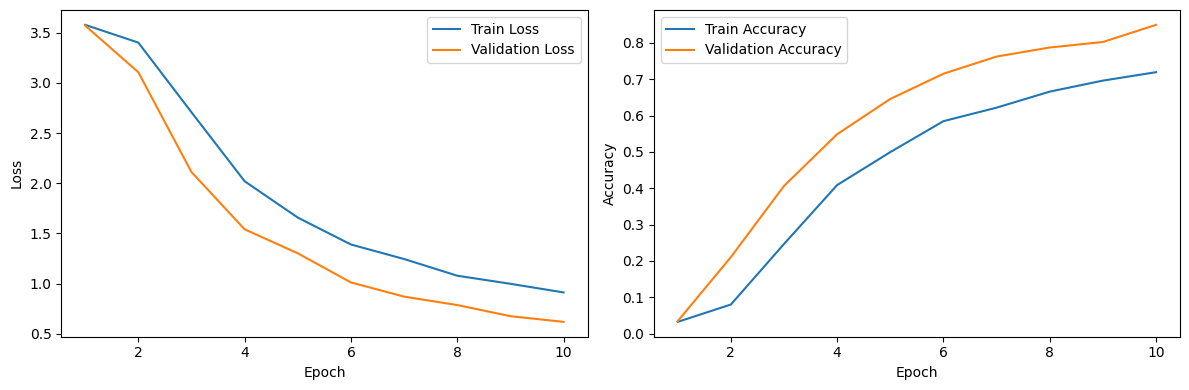

In [11]:
# Plot the learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()